# Learning Expensive Functions

*This notebook first appeared as a [blog post](//betatim.github.io/posts/learning-expensive-functions) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2015, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

Powerful features (or variables) are often expensive to compute. Maybe they require a lot of CPU power to compute or require human interaction. As a result the size of the datasets for which the features are evaluated are smaller than they should be.

This post explores a possible way around this. Regression algorithms can learn complex functions and are cheap to evaluate. The idea then is:

* Train a regression algorithm on a small subset of the data for which all expensive features have been calculated
* Use this algorithm to cheaply calculate the features for a much larger number of samples

Here I demonstrate this approach using a feature called "[Missing mass calculator](//arxiv.org/abs/1012.4686)". It is used in searches for the [Higgs boson](//en.wikipedia.org/wiki/Higgs_boson) and takes about one minute to calculate per sample (or event). A minute per event! That does not sound much until you realise a typical analysis at the [LHC](//home.web.cern.ch/topics/large-hadron-collider) uses millions or even tens of millions of events.

First some imports and loading the data:

In [1]:
%matplotlib inline

In [2]:
from operator import itemgetter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

The HiggsML challenge dataset has been released to the public. It contains the Missing Mass Calculator (`MMC`) variable as a feature, let's try and see if we can learn to compute it with a regression model. This is an interesting challenge as the process to calculate the `MMC` feature is quite involved (good luck implementing it from [the description in the paper](//arxiv.org/abs/1012.4686) ...). Let's go!

The next cell downloads the full dataset from CERN's opendata portal to your `/tmp` directory:

In [3]:
%%bash
# Download the HiggsML dataset
# details here: http://opendata.cern.ch/record/328
wget --quiet -P /tmp/ http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz

Read it all in to a `pandas` `DataFrame`, directly from a compressed csv. We also print out the name of all the columns, the important part to notice is that there are several features which have nothing to do with `MMC` which we can use to predict it, as well as weights for each sample.

In [4]:
df = pd.read_csv('/tmp/atlas-higgs-challenge-2014-v2.csv.gz',
                 compression='gzip')

# Print the name of all the colums
print ', '.join(df.columns)

EventId, DER_mass_MMC, DER_mass_transverse_met_lep, DER_mass_vis, DER_pt_h, DER_deltaeta_jet_jet, DER_mass_jet_jet, DER_prodeta_jet_jet, DER_deltar_tau_lep, DER_pt_tot, DER_sum_pt, DER_pt_ratio_lep_tau, DER_met_phi_centrality, DER_lep_eta_centrality, PRI_tau_pt, PRI_tau_eta, PRI_tau_phi, PRI_lep_pt, PRI_lep_eta, PRI_lep_phi, PRI_met, PRI_met_phi, PRI_met_sumet, PRI_jet_num, PRI_jet_leading_pt, PRI_jet_leading_eta, PRI_jet_leading_phi, PRI_jet_subleading_pt, PRI_jet_subleading_eta, PRI_jet_subleading_phi, PRI_jet_all_pt, Weight, Label, KaggleSet, KaggleWeight


## An expensive feature

Let's take a look at the feature we want to try and learn. The idea behind the "Missing Mass Calculator" is to construct a variable that distinguishes between events containing a Higgs and ones that do not. One way is to try and reconstruct the mass of the Higgs boson. In events with a Higgs that should give you something close to the Higgs mass (125 GeV) and different values for events without a Higgs in them.

In the following plot background events (those which are not the Higgs) are shown in blue and events containing a Higgs boson are shown in red.

First thing to notice is that the red distribution is multiplied by a factor of 100! This is just to make it visible. Otherwise events containing a Higgs are so rare they are impossible to see compared to the background.

As expected the red distribution peaks around 125 GeV and the background peaks at lower values. The peak is also much broader.

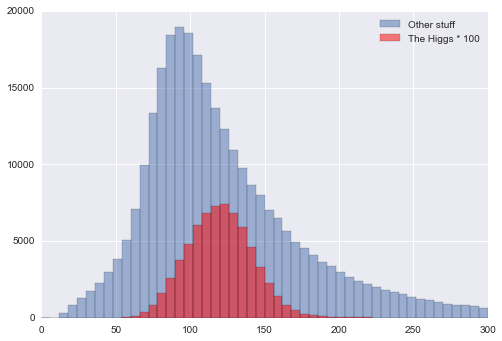

In [5]:
hist_opts = dict(alpha=0.5,
                 bins=50,
                 range=(0,300))
signal = df.Label == 's'
_=plt.hist(df.DER_mass_MMC[~signal].as_matrix(),
           weights=df.Weight[~signal].as_matrix(),
           label='Other stuff',
           **hist_opts)
_=plt.hist(df.DER_mass_MMC[signal],
           weights=df.Weight[signal] * 100,
           label='The Higgs * 100',
           color='r',
           **hist_opts)
plt.legend(loc='best')

## Data loading and the train-test split

Next let's convert the data frame to a plain numpy arrays and separate the samples by whether they contain a Higgs boson or not.

In [27]:
# Selecting the columns used to predict MMC
columns = ['PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
           'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi',
           'PRI_met', 'PRI_met_phi', 'PRI_met_sumet',
           'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
           'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
           'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
           'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h',
           'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
           'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot',
           'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
           'DER_lep_eta_centrality'
           ]

# For some samples/events the MMC could not be calculated
# they are marked with a value < -800
# Split the data by whether the sample represents a Higgs (signal)
# boson event or not (background)
signal = df[(df.Label == 's') & (df.DER_mass_MMC > -800)]
X = signal[columns]
w = signal['Weight']
MMC = signal['DER_mass_MMC']

background = df[(df.Label == 'b') & (df.DER_mass_MMC > -800)]
bg_X = background[columns]
bg_w = background['Weight']
bg_MMC = background['DER_mass_MMC']

Split signal and background into development and evaluation sets as well as the development set into a training and testing one. It is important to keep some events hidden from your model evaluation and selection procedure so you can evaluate the models true performance.

In [28]:
# this looks more daunting than it has to be :-(
X_dev,X_eval, w_dev,w_eval, MMC_dev,MMC_eval = train_test_split(X.as_matrix(),
                                                                w.as_matrix(),
                                                                MMC.as_matrix(),
                                                                random_state=9548)

bg_X_dev,bg_X_eval, bg_w_dev,bg_w_eval, bg_MMC_dev,bg_MMC_eval = train_test_split(bg_X.as_matrix(),
                                                                                 bg_w.as_matrix(),
                                                                                 bg_MMC.as_matrix(),
                                                                                 random_state=958)

X_train,X_test, w_train,w_test, MMC_train,MMC_test = train_test_split(X_dev, w_dev, MMC_dev,
                                                                  random_state=2171)
bg_X_train,bg_X_test, bg_MMC_train,bg_MMC_test, bg_w_train,bg_w_test = train_test_split(
                                                              bg_X_dev, bg_MMC_dev, bg_w_dev,
                                                              train_size=0.666, random_state=4685)

## Regression trees

The plan is to train a regressor which given the input variables can predict the MMC feature for us. After some `GridSearchCV` I found the hyper-parameters used below. They work quite well but we could probably do even better if we spent more CPU time. (While the hyper-parameter optimisation is not shown here, we still have to split the data the same way as the performance evaluated on the test set is biased optimistically due to doing some fairly exhaustive searching.)

In [29]:
clf = GradientBoostingRegressor(n_estimators=2000,
                                learning_rate=0.05,
                                subsample=0.7296635812586656,
                                max_features=0.5779758681446561,
                                max_depth=5,
                                loss='ls')

clf.fit(X_train, MMC_train, w_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.05, loss='ls',
             max_depth=5, max_features=0.577975868145, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             random_state=None, subsample=0.729663581259, verbose=0,
             warm_start=False)

Let's compare the MMC feature computed by the regression model with the true value. If we are doing a good job they should be pretty similar. Crucially we do not re-use samples used during the training to evaluate the performance.

In [30]:
MMC_pred_train = clf.predict(X_train)
MMC_pred_test = clf.predict(X_test)
MMC_pred_eval = clf.predict(X_eval)

bg_MMC_pred_test = clf.predict(bg_X_test)
bg_MMC_pred_eval = clf.predict(bg_X_eval)

print "MSE on training set:",
print mean_squared_error(MMC_train, MMC_pred_train, w_train)
print "MSE on testing set:",
print mean_squared_error(MMC_test, MMC_pred_test, w_test)
print "MSE on evaluation set:",
print mean_squared_error(MMC_eval, MMC_pred_eval, w_eval)

MSE on training set: 12.2873639683
MSE on testing set: 26.276874694
MSE on evaluation set: 34.3325667757


As you can see the model performs much better on the training set than on the samples in the testing set. The most important point to note though is that the performance estimate you obtain from the test set is **also** optimistic. This is the result of the sum of testing and training being used during the optimisation of the hyper-parameters. This is why it is crucial to reserve a third set of samples which is only looked at after you fix all parameters. In our case it is `MMC_eval`.

## Learned versus Original

So, after all this, how well does our learned MMC regressor do? Let's compared the distribution of the MMC feature as computed the slow way and the learned MMC feature. By eye they look extremely similar, which is nice. This means you could use this approach of learning an expensive to calculate feature (or variable) and use that as a proxy which is much faster to evaluate.

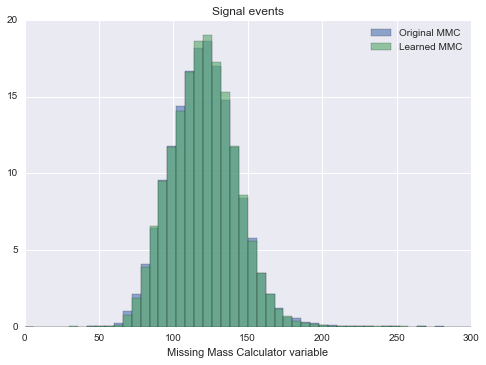

In [35]:
opts = dict(alpha=0.6, bins=50, range=(0,300))
plt.hist(MMC_eval, weights=w_eval,
         label="Original MMC", **opts)
plt.hist(MMC_pred_eval, weights=w_eval,
         label="Learned MMC", **opts)
plt.xlabel("Missing Mass Calculator variable")
plt.legend(loc='best')
plt.title("Signal events")

## Raising the bar

Did our regression model learn anything useful? Maybe it just memorised how the input features are related to MMC, but otherwise gained no insight. Did you notice that we only used samples containing a Higgs boson so far? That was on purpose. It means not only do we have a large set of samples which where never used during model evaluation and selection, in addition these are quite different types of events.

The next figure compares the original MMC feature with the regression model's calculation. The agreement is not as good as for the Higgs boson class but it does quite well.

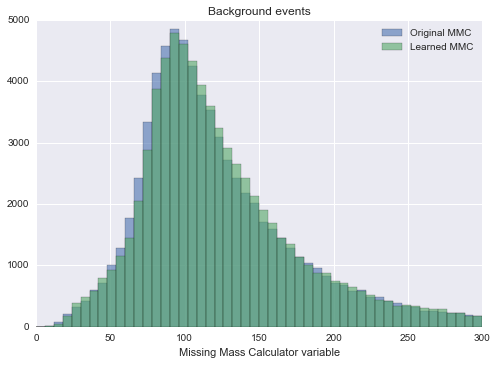

In [36]:
plt.hist(bg_MMC_eval, weights=bg_w_eval,
         label="Original MMC", **opts)
plt.hist(bg_MMC_pred_eval, weights=bg_w_eval,
         label="Learned MMC", **opts)

plt.xlabel("Missing Mass Calculator variable")
plt.legend(loc='best')
plt.title("Background events")

While it is not absolute proof that the regression model actually learnt something about physics, the fact that it can compute the MMC feature even for a totally different class of samples does suggest that it learnt something.

Another way of evaluating the performance is to plot the difference between the original MMC feature's value and the MMC value calculated by the regression model for each sample.

(-0.038939916353662653, 5.770798070300847)
(-1.7394594313468719, 14.574445902019193)


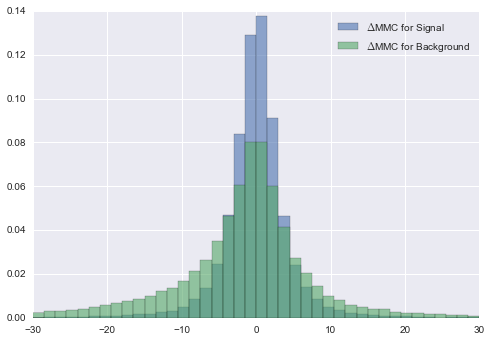

In [25]:
def mean_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

delta = y_eval - MMC_pred_eval
bg_delta = bg_y_eval - bg_MMC_pred_eval

_=plt.hist(delta, weights=w_eval,
           alpha=0.6,
           bins=40, range=(-30,30),
           label='$\Delta$MMC for Signal',
           normed=True)
_=plt.hist(bg_delta, weights=bg_w_eval,
           alpha=0.6,
           bins=40, range=(-30,30),
           label='$\Delta$MMC for Background',
           normed=True)

plt.legend(loc='best')
print mean_and_std(delta, weights=w_eval)
print mean_and_std(bg_delta, weights=bg_w_eval)

As you can see the spread between the original MMC feature and the learned one is quite small, around 6. Improtantly the average difference is basically zero. This means the regression model does not favour one value over another.

Unsurprisingly the spread is larger for background events which are a different kind of beast all together compared to the ones we used during training.

In a real world application you would use some background events and some signal events to train the regression model. This will improve the performance of the model on this class of events. Here I choose not to include them as I wanted to see how well the model does on events which are not only new but also quite different from the ones used during training.

## The end

Often the most powerful features in a dataset (for example for classifying Higgs events) are also the most expensive to compute in terms of CPU time or actual human time. Often this limits the number of samples in your dataset. Here I showed that you can get away with computing an expensive feature for a small subset of your events and then use a regression model to calculate it for a much larger number of samples.

You can also apply this idea to the large, from first principle simulations of the LHCb, ATLAS and CMS detectors. These simulations use over half of the total CPU time of the LHC computing grid, so speeding them up has huge potential!

As far as I know this has not really been used in particle physics so far, let me know if you know of other examples where it has been used!

If you find a mistake or want to tell me something else get in touch on twitter @[betatim](//twitter.com/betatim)